In [1]:
import geopandas as gdp
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
import re
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.dates as mdates


DATA_DIR = 'Data/'

def get_offsets(header_lines):
    # Capture important information from the header
    offset_pattern = re.compile(r"#\s*(\*?)\s*offset\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    ps_decay_pattern = re.compile(r'(?:(#!)?\s*ps decay\s+\d:\s*(-?\d+\.\d+)\s+\+/-\s+(\d+\.\d+)\s+mm\s+\((\d{4}-\d{2}-\d{2})\s+\[(\d{4}\.\d+)\]\);\s*tau:\s*(\d+)\s+days)')
    component_pattern = re.compile(r"#\s+([neu])\s+component")

    components = {'n': {'offsets': [], 'ps_decays': []}, 'e': {'offsets': [], 'ps_decays': []}, 'u': {'offsets': [], 'ps_decays': []}}
    current_component = None

    for line in header_lines:
        comp_match = component_pattern.match(line)
        if comp_match:
            current_component = comp_match.group(1)
            continue

        # Check for offset
        offset_match = offset_pattern.match(line)
        if offset_match and current_component:
            coseismic = bool(offset_match.group(1))  # True if * present, meaning coseismic
            offset_value = float(offset_match.group(2))
            offset_error = float(offset_match.group(3))
            offset_date = offset_match.group(4)
            components[current_component]['offsets'].append({
                'value': offset_value,
                'error': offset_error,
                'date': offset_date,
                'coseismic': coseismic
            })

        # Check for postseismic decay
        ps_decay_match = ps_decay_pattern.match(line)
        if ps_decay_match:
            if current_component:
                decay_type = 'logarithmic' if ps_decay_match.group(1) else 'exponential'
                decay_value = float(ps_decay_match.group(2))
                decay_error = float(ps_decay_match.group(3))
                decay_date = ps_decay_match.group(4)
                tau = int(ps_decay_match.group(6))
                components[current_component]['ps_decays'].append({
                    'value': decay_value,
                    'error': decay_error,
                    'tau': tau,
                    'date': decay_date,
                    'type': decay_type
                })

    return components

def read_file(filename):
    
    with open(DATA_DIR+filename, 'r') as file:
        lines = file.readlines()

    header_lines = [line for line in lines if line.startswith('#')]
    if header_lines:
        column_names = re.split(r'\s{2,}', header_lines[-1].lstrip('#').strip())
    else:
        column_names = []
        
    data_lines = []
    for line in lines:
        if not line.startswith('#'):
            parts = line.strip().split()
            # Check if the number of parts matches the expected number of columns
            if len(parts) < len(column_names):
                # Add None for missing values
                parts.extend([None] * (len(column_names) - len(parts)))
            data_lines.append(parts)

    data = pd.DataFrame(data_lines)
    data.columns = column_names
    
    # Extracts latitude, longitude and height
    pattern = r'Latitude\(DD\)\s*:\s*(-?\d+\.\d+)|East Longitude\(DD\)\s*:\s*(-?\d+\.\d+)|Height\s*\(M\)\s*:\s*(-?\d+\.\d+)'
    #referece_pattern = r'Reference_X\s*:\s*(-?\d+\.\d+)|Reference_Y\s*:\s*(-?\d+\.\d+)|Reference_Z\s*:\s*(-?\d+\.\d+)'
    matches = re.findall(pattern, ' '.join(header_lines))
    geom = Point(float(matches[1][1]), float(matches[0][0]))
    
    offsets = get_offsets(header_lines)

    data['Date'] = pd.to_datetime(data['Yr'].astype(str) + data['DayOfYr'].astype(str), format='%Y%j')
    data.set_index('Date', inplace=True)
    data.drop(['Dec Yr', 'Yr', 'DayOfYr'], axis=1, inplace=True)
    cols = ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']
    data[cols] = data[cols].astype(float)
    
    data.name = filename.replace("RawTrend.neu", "")
    data.attrs['geometry'] = geom
    data.attrs['height'] = float(matches[2][2])
    data.attrs['offsets'] = offsets
    
    return data

In [2]:
def organize_files():
    gdfs = []
    dir = Path(DATA_DIR)
    for file_path in dir.iterdir():
        if file_path.is_file():
            gdfs.append(read_file(file_path.name))
    return gdfs

In [5]:
def get_geometries(dfs):
    return gdp.GeoDataFrame(geometry=[df.attrs['geometry'] for df in dfs])

In [6]:
def plot_stations(dfs):
    gdf = get_geometries(dfs)
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=3857, inplace=True)
    ax = gdf.plot(marker='o', color='red', markersize=10, figsize=(20, 20))
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.show()

In [7]:
dfs = organize_files()

In [65]:
def plot_logarithmic_decay(ax, decay, tau, value):
    """
    Plot logarithmic decay starting from the decay's date.
    """
    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    # Logarithmic decay curve
    decay_curve = value * np.log(1 + time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='-', color='y')
    return line

def plot_exponential_decay(ax, decay, tau, value):
    """
    Plot exponential decay starting from the decay's date.
    """
    decay_start = pd.to_datetime(decay['date'])
    time_range = pd.date_range(decay_start, periods=100, freq='D')
    time_since_start = (time_range - decay_start).days
    
    # Exponential decay curve
    decay_curve = value * np.exp(-time_since_start / tau)
    
    line, = ax.plot(time_range, decay_curve, linestyle='--', color='g')
    return line

def plot_time_series(df, cols, titles, offset_date=None, zoom_days=300, xlabel='Date', ylabel='Data', 
                     second_ylabel='Secondary Data', error_scale=1, decay_duration_factor=3, plot_decays=True):
    
    # Create subplots
    fig, axs = plt.subplots(1, len(cols), figsize=(15, 5), sharey=False)

    # Convert original data from meters to millimeters
    for col in cols:
        if col not in ['CorrNE', 'CorrNU', 'CorrEU']:
            df[col] *= 1000

    # If an offset_date is provided, zoom in around it; otherwise, plot the whole range
    if offset_date:
        offset_date = pd.to_datetime(offset_date)
        start_date = offset_date - pd.Timedelta(days=zoom_days)
        end_date = offset_date + pd.Timedelta(days=zoom_days)
        
        # Filter the dataframe to focus only on the relevant time window
        df_zoomed = df.loc[(df.index >= start_date) & (df.index <= end_date)]
    else:
        # No offset date, use the entire time range
        df_zoomed = df

    # Plotting the main time-series data
    df_zoomed[cols].plot(ax=axs, subplots=True, legend=False, style='o', ylabel=ylabel, xlabel=xlabel, color='b', label='_nolegend_')

    # Set titles for each subplot
    for ind, ax in enumerate(axs): 
        ax.set_title(f'Station: {df.name}\n{titles[ind]}')

        # Rotate x-axis labels for better readability
        for label in ax.get_xticklabels():
            label.set_rotation(45)

        # Limit the number of x-ticks to avoid crowding
        if offset_date:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=5))
        else:
            ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

        # Set x-axis format for dates
        if offset_date:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        else:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    components = ['n', 'e', 'u']
    offsets_data = df.attrs['offsets']

    # Create secondary y-axes for offsets
    secondary_y_axes = [ax.twinx() for ax in axs]

    for i, component in enumerate(components):
        # Get the offsets and decays for the current component
        comp_offsets = offsets_data[component]['offsets']
        comp_decays = offsets_data[component].get('ps_decays', [])

        handles = []
        labels = []

        # Plot offsets with potentially scaled error bars
        for offset in comp_offsets:
            linestyle = '-' if offset.get('coseismic', False) else '--'
            color = 'r' if linestyle == '-' else 'orange'
            label = ('Coseismic Offset' if offset.get('coseismic', False) else 'Non-coseismic Offset')
            marker = 'o' if linestyle == '-' else 's'
            
            secondary_y_axes[i].errorbar(
                pd.to_datetime(offset['date']),
                offset['value'],
                yerr=offset['error'] * error_scale,
                fmt=marker,
                markersize=10,
                capsize=5,
                capthick=2,
                color=color,
                label=label
            )
            
            if label not in labels:
                handles.append(plt.Line2D([0], [0], marker=marker, color='w', label=label, markerfacecolor=color))
                labels.append(label)

        # Plot decays as curves over time if enabled
        if plot_decays:
            for decay in comp_decays:
                decay_type = decay['type']
                tau = decay['tau']
                value = decay['value']

                if decay_type == 'logarithmic':
                    line = plot_logarithmic_decay(axs[i], decay, tau, value)
                    handles.append(line) 
                    labels.append('Logarithmic Decay')

                elif decay_type == 'exponential':
                    line = plot_exponential_decay(axs[i], decay, tau, value)
                    handles.append(line)
                    labels.append('Exponential Decay')

        if i == 0:
            axs[i].set_ylabel(ylabel)
        else:
            axs[i].set_ylabel('')

        if i == len(cols) and second_ylabel:
            secondary_y_axes[i].set_ylabel(second_ylabel)

        # Set x-axis limits if zooming around the offset
        if offset_date:
            axs[i].set_xlim(start_date, end_date)

    if handles:
        axs[0].legend(handles, labels, loc='best')

    plt.tight_layout()
    plt.show()


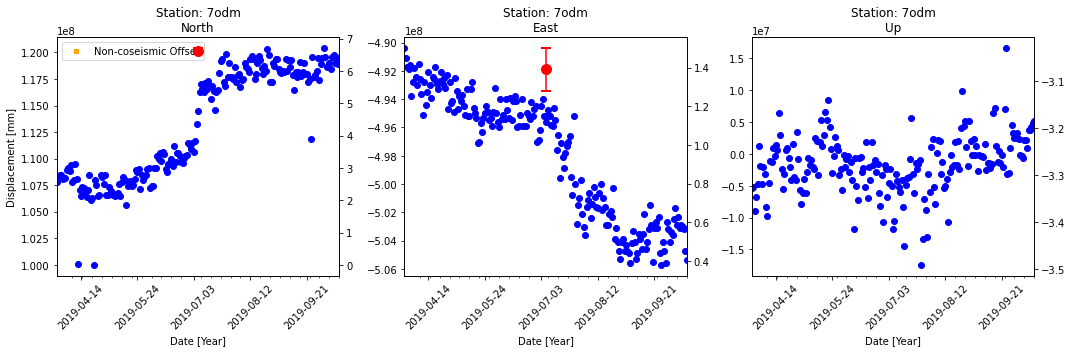

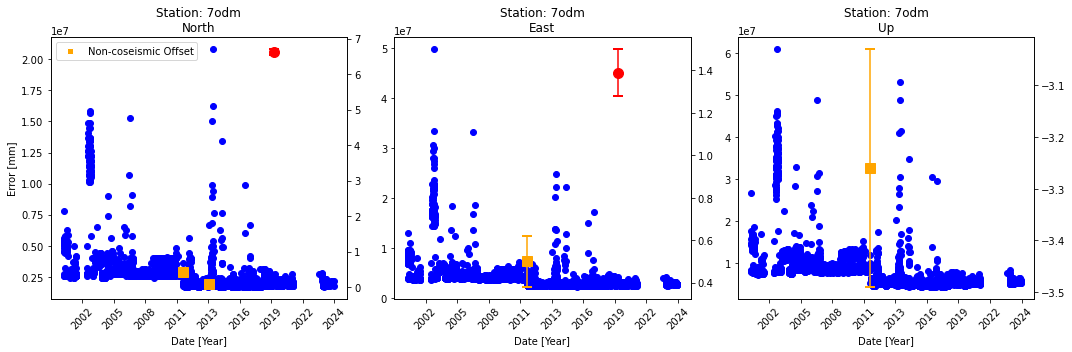

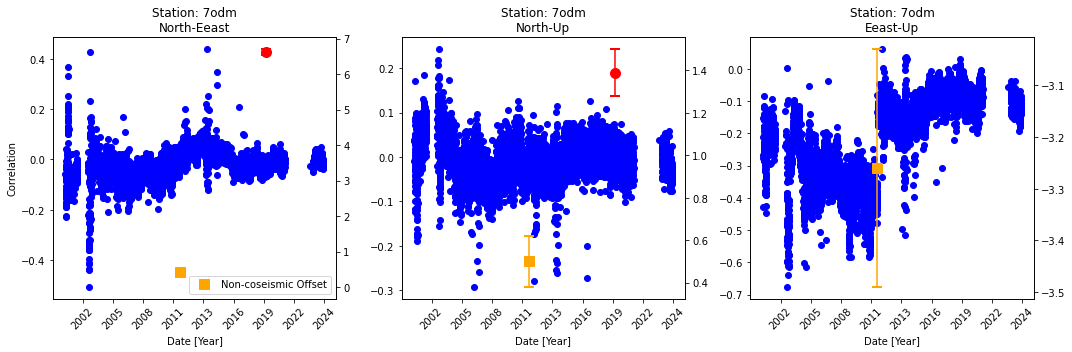

In [66]:
plot_time_series(dfs[4], ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [mm]', xlabel='Date [Year]', second_ylabel='Offsets [mm]', offset_date=dfs[4].attrs['offsets']['n']['offsets'][0]['date'], zoom_days=100, plot_decays=True)
plot_time_series(dfs[4], ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [mm]', xlabel='Date [Year]', second_ylabel= 'Offsets [mm]', plot_decays=False)
plot_time_series(dfs[4], ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-Eeast', 'North-Up', 'Eeast-Up'], ylabel='Correlation', xlabel='Date [Year]', second_ylabel='Offsets [mm]', plot_decays=False)

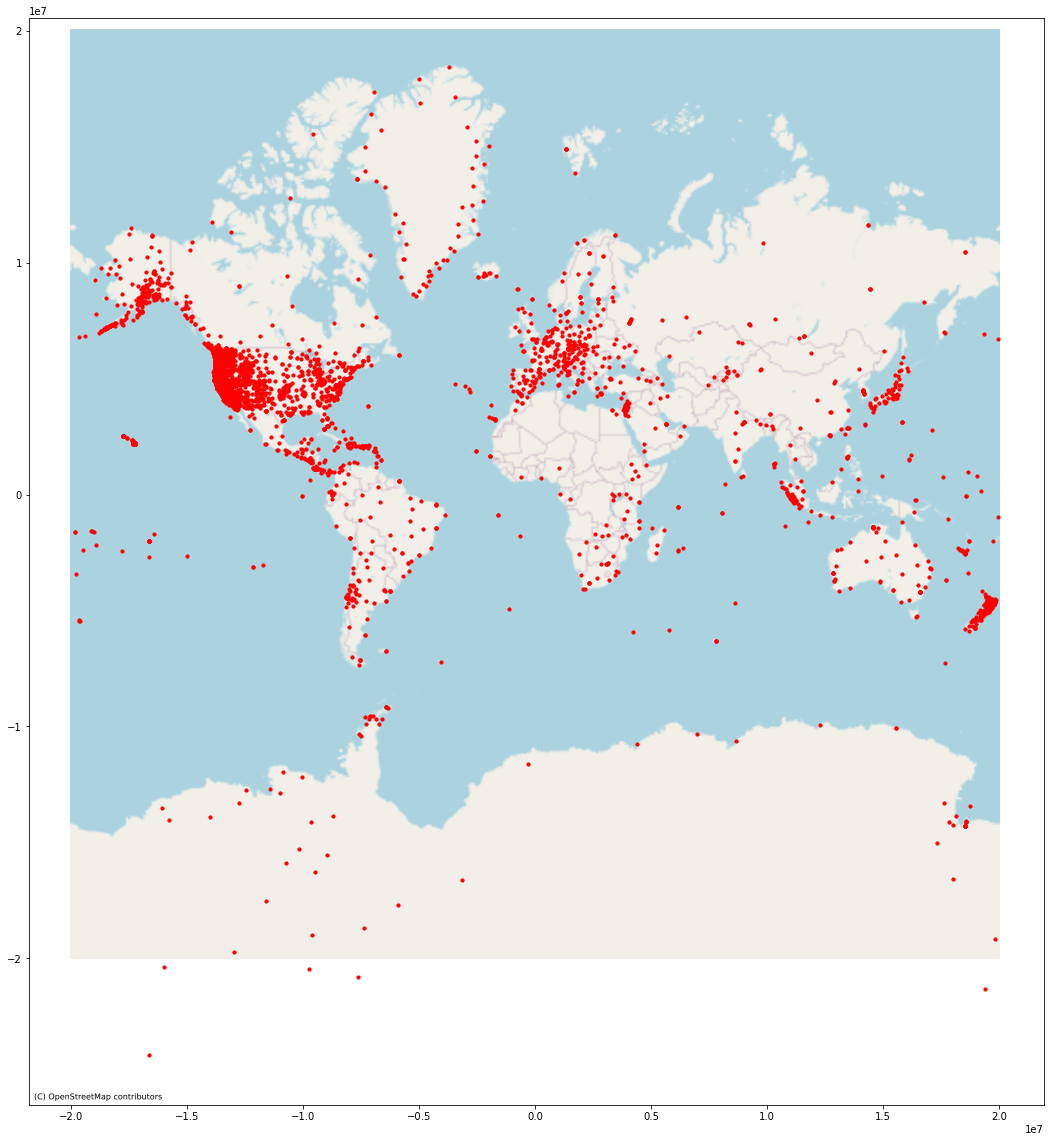

In [11]:
plot_stations(dfs)